# 🔥 Qwen2.5-VL Model Attribution

In [1]:
import os
os.chdir("../")

In [2]:
# Set the huggingface mirror and cache path
os.environ["HF_ENDPOINT"] = "https://hf-mirror.com" # for Chinese
os.environ["HF_HOME"] = "./model_checkpoint/hf_cache"


from transformers import Qwen2_5_VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info

import torch
from torch import nn
import torchvision.transforms.functional as TF

import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from interpretation.submodular_vision import MLLMSubModularExplanationVision

from utils import SubRegionDivision
from visualization.visualization import visualization_mllm, visualization_mllm_with_object

/home/cry/anaconda3/envs/qwen/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def imshow(img):
    """
    Visualizing images inside jupyter notebook
    """
    plt.axis('off')
    if len(img.shape)==3:
        img = img[:,:,::-1] 	# transform image to rgb
    else:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    plt.imshow(img)
    plt.show()

In [4]:
class QwenVLAdaptor(torch.nn.Module):
    def __init__(self, 
                 model,
                 processor,
                 device = "cuda"):
        super().__init__()
        self.model = model
        self.device = device
        self.softmax = nn.Softmax(dim=-1)
        
        self.processor = processor
        
        self.generated_ids = None
        
        # The position of the token that needs to be explained in the newly generated content (include all tokens)
        self.target_token_position = None
        self.selected_interpretation_token_word_id = None
    
    def forward(self, image):
        """_summary_

        Args:
            image: PIL format
        """
        if isinstance(image, torch.Tensor):
            if image.shape[-1] == 3:
                image_tensor = image[..., [2, 1, 0]]  # BGR → RGB
                image_tensor = image_tensor.permute(2, 0, 1)
                image_tensor = image_tensor.clamp(0, 255).byte()
                image = TF.to_pil_image(image_tensor)
                
        info = [
            {
                "role": "user",
                "content": [
                    {
                        "type": "image",
                        "image": image,
                    },
                ],},
            ]
        
        # Preparation for inference
        text = self.processor.apply_chat_template(
            info, tokenize=False, add_generation_prompt=True)
        image_inputs, video_inputs = process_vision_info(info)
        
        inputs = self.processor(
            text=[text],
            images=image_inputs,    # 这里可以多个
            padding=True,
            return_tensors="pt",
        )
        self.generated_ids = self.generated_ids[:max(self.target_token_position)]   #bug
        inputs['input_ids'] = self.generated_ids
        inputs['attention_mask'] = torch.ones_like(self.generated_ids)
        inputs = inputs.to(self.model.device)    # dict_keys(['input_ids', 'attention_mask', 'pixel_values', 'image_grid_thw'])
        
        # Forward calculation to get all logits (including the logits of the input part)
        with torch.no_grad():
            outputs = self.model(
                **inputs,
                return_dict=True,
                use_cache=True,
            )
            all_logits = outputs.logits  # [batch_size, seq_len, vocab_size]
        
        if self.generated_ids != None:
            returned_logits = all_logits[:, self.target_token_position - 1] # The reason for the minus 1 is that the generated content is in the previous position
            returned_logits = self.softmax(returned_logits)
            
            if self.selected_interpretation_token_word_id != None:
                self.selected_interpretation_token_word_id = torch.tensor(self.selected_interpretation_token_word_id).to(self.model.device)
                indices = self.selected_interpretation_token_word_id.unsqueeze(0).unsqueeze(-1) # [1, N, 1]
                
                returned_logits = returned_logits.gather(dim=2, index=indices) # [1, N, 1]
                
                returned_logits = returned_logits.squeeze(-1)  # [1, N]
        return returned_logits[0]   # size [N]

## Load the Qwen Model

In [5]:
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2.5-VL-3B-Instruct", torch_dtype="auto", device_map="auto"
)
model.eval()

# default processor
processor = AutoProcessor.from_pretrained("Qwen/Qwen2.5-VL-3B-Instruct")
tokenizer = processor.tokenizer

# Encapsulation Qwen
Qwen = QwenVLAdaptor(
    model = model,
    processor = processor
)

Loading checkpoint shards: 100%|██████████| 2/2 [00:38<00:00, 19.34s/it]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


## Load the Explainer

In [6]:
explainer = MLLMSubModularExplanationVision(
    Qwen
)

cuda


## Load the Image

In [7]:
image_path = "./examples/cat_on_a_tree.jpg"
text_prompt = "Describe the image in one factual English sentence of no more than 20 words. Do not include information that is not clearly visible."
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": image_path,
            },
            {"type": "text", "text": text_prompt},
        ],
    }
]

In [8]:
# Preparation for inference
text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)
image_inputs, video_inputs = process_vision_info(messages)

# Data proccessing
inputs = processor(
    text=[text],
    images=image_inputs,    # 这里可以多个
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to(model.device)    # dict_keys(['input_ids', 'attention_mask', 'pixel_values', 'image_grid_thw'])

# Inference: Generation of the output
with torch.no_grad():
    generated_ids = model.generate(
        **inputs, 
        do_sample=False,      # Disable sampling and use greedy search instead
        num_beams=1,          # Set to 1 to ensure greedy search instead of beam search.
        max_new_tokens=128)
    generated_ids_trimmed = [   # 去掉图像和prompt的文本
        out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]
    
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)
output_words = processor.batch_decode(
    generated_ids_trimmed[0], skip_special_tokens=True, clean_up_tokenization_spaces=False
)
print(output_text)
print(output_words)
print(generated_ids_trimmed)

/home/cry/anaconda3/envs/qwen/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:634: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `1e-06` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


['A cat sits on a branch among green bananas and large leaves against a clear blue sky.']
['A', ' cat', ' sits', ' on', ' a', ' branch', ' among', ' green', ' bananas', ' and', ' large', ' leaves', ' against', ' a', ' clear', ' blue', ' sky', '.', '']
[tensor([    32,   8251,  23011,    389,    264,   8870,   4221,   6176,  67342,
           323,   3460,  10901,   2348,    264,   2797,   6303,  12884,     13,
        151645], device='cuda:0')]


We can see the individual words in this passage and their generated ids. For example, `cat` is located in the second generated token, and its ID is `8251`.

## 😮 Sentence-level Interpretation

In [9]:
# Select all words to explain
selected_interpretation_token_id = [i for i in range(len(output_words))]
selected_interpretation_token_word_id = generated_ids_trimmed[0].tolist()

In [10]:
## Equip the model with the generated ids and the target token position to be explained
Qwen.generated_ids = generated_ids
Qwen.target_token_position = np.array(selected_interpretation_token_id) + len(inputs['input_ids'][0])
Qwen.selected_interpretation_token_word_id = selected_interpretation_token_word_id

In [11]:
# Image division
image = cv2.imread(image_path)
    
# Sub-region division
region_size = int((image.shape[0] * image.shape[1] / 50) ** 0.5)
V_set = SubRegionDivision(image, region_size = region_size)

In [12]:
## Begin to explain
S_set, saved_json_file = explainer(image, V_set)
saved_json_file["selected_interpretation_token_id"] = selected_interpretation_token_id
saved_json_file["selected_interpretation_token_word_id"] = selected_interpretation_token_word_id
saved_json_file["words"] = output_words

  0%|          | 0/48 [00:00<?, ?it/s]/tmp/ipykernel_1141507/1304013285.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.selected_interpretation_token_word_id = torch.tensor(self.selected_interpretation_token_word_id).to(self.model.device)
100%|██████████| 48/48 [10:12<00:00, 12.76s/it]


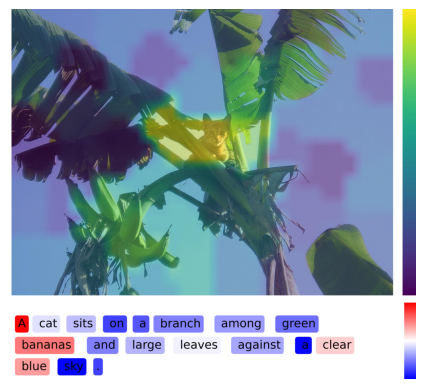

In [13]:
## Visualization
visualization_mllm(image_path, S_set, saved_json_file, save_path="examples/explanation_cat_on_a_tree.jpg")
sentence_level_visualization_img = cv2.imread("examples/explanation_cat_on_a_tree.jpg")
imshow(sentence_level_visualization_img)


## 😮 Word-level Interpretation
In this case, we take the explanation word `cat` as an example

In [33]:
# Select all words to explain
selected_interpretation_token_id = [1]
selected_interpretation_token_word_id = [generated_ids_trimmed[0][1].item()]

## Equip the model with the generated ids and the target token position to be explained
Qwen.generated_ids = generated_ids
Qwen.target_token_position = np.array(selected_interpretation_token_id) + len(inputs['input_ids'][0])
Qwen.selected_interpretation_token_word_id = selected_interpretation_token_word_id

In [35]:
# Image division
image = cv2.imread(image_path)
    
# Sub-region division
region_size = int((image.shape[0] * image.shape[1] / 50) ** 0.5)
V_set = SubRegionDivision(image, region_size = region_size)

In [ ]:
## Begin to explain
S_set, saved_json_file = explainer(image, V_set)
saved_json_file["selected_interpretation_token_id"] = selected_interpretation_token_id
saved_json_file["selected_interpretation_token_word_id"] = selected_interpretation_token_word_id


  0%|          | 0/48 [00:00<?, ?it/s]/tmp/ipykernel_366063/1304013285.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.selected_interpretation_token_word_id = torch.tensor(self.selected_interpretation_token_word_id).to(self.model.device)
100%|██████████| 48/48 [22:14<00:00, 27.80s/it]


0.8035125732421875


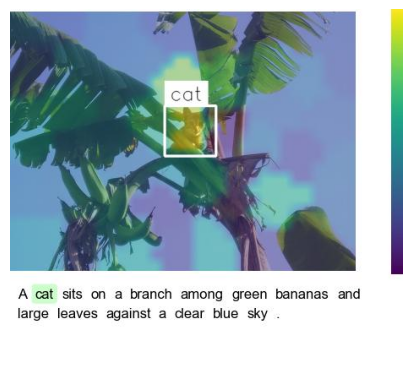

In [46]:
## Visualization
saved_json_file["location"] = [286,174,381,267]
saved_json_file["select_category"] = "cat"
saved_json_file["output_words"] = output_words

visualization_mllm_with_object(image_path, S_set, saved_json_file, save_path="examples/explanation_word_cat_on_a_tree.jpg")
word_level_visualization_img = cv2.imread("examples/explanation_word_cat_on_a_tree.jpg")
imshow(word_level_visualization_img)

We can also try to explain the word `banana`

In [53]:
# Select all words to explain
selected_interpretation_token_id = [8]
selected_interpretation_token_word_id = [generated_ids_trimmed[0][8].item()]

## Equip the model with the generated ids and the target token position to be explained
Qwen.generated_ids = generated_ids
Qwen.target_token_position = np.array(selected_interpretation_token_id) + len(inputs['input_ids'][0])
Qwen.selected_interpretation_token_word_id = selected_interpretation_token_word_id

In [54]:
## Begin to explain
S_set, saved_json_file = explainer(image, V_set)
saved_json_file["selected_interpretation_token_id"] = selected_interpretation_token_id
saved_json_file["selected_interpretation_token_word_id"] = selected_interpretation_token_word_id

100%|██████████| 48/48 [14:25<00:00, 18.03s/it]


0.9842500686645508


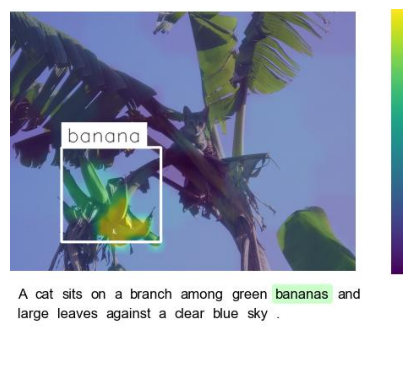

In [55]:
## Visualization
saved_json_file["location"] = [95, 251, 279, 426]
saved_json_file["select_category"] = "banana"
saved_json_file["output_words"] = output_words

visualization_mllm_with_object(image_path, S_set, saved_json_file, save_path="examples/explanation_word_banana_cat_on_a_tree.jpg")
word_level_visualization_img = cv2.imread("examples/explanation_word_banana_cat_on_a_tree.jpg")
imshow(word_level_visualization_img)